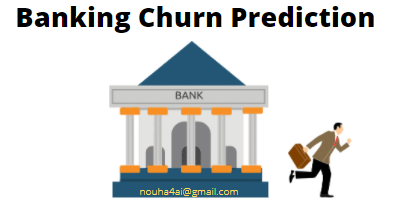

> **Notebook author: EL ABED N.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import plotly.express as px
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, precision_score, recall_score

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('fivethirtyeight')

In [3]:
bank_df=pd.read_csv('../input/bank-customer-churn-prediction/Churn_Modelling.csv')

In [4]:
bank_df.head()

>  This dataset is originated from a U.S. bank .

In [5]:
bank_df.shape

In [6]:
bank_df.info()

## **Data visualization**

In [7]:
def distribution(dataframe:pd.DataFrame,
                 colunm:str
                ):
    min_col=dataframe[colunm].min()
    max_col=dataframe[colunm].max()
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=dataframe[dataframe['Exited']==1][colunm],
        histnorm='percent',
        name=True,
        xbins=dict( 
            start=min_col,
            end=max_col
        ),
        marker_color='red',
        opacity=0.75))
    fig.add_trace(go.Histogram(
        x=dataframe[dataframe['Exited']==0][colunm],
        histnorm='percent',
        name=False,
        xbins=dict(
            start=min_col,
            end=max_col
        ),
        marker_color='blue',
        opacity=0.75
    ))
    fig.update_layout(
        title_text=f'Distribution of {colunm} feature', 
        xaxis_title_text='Values', 
        yaxis_title_text='Percentage', 
        bargap=0.2, 
        bargroupgap=0.1 
    )
    fig.show()

In [8]:
distribution(bank_df, 'Age')

In [9]:
fig = px.histogram(bank_df, 
                   y="Gender", 
                   color='Exited', 
                   text_auto=True,
                   width=700,
                   height=300,
                   title='Exited by gender')
fig.show()
exit_by_gender=bank_df.groupby(['Exited','Gender'])['CustomerId'].count()
exit_by_gender_df=pd.DataFrame(exit_by_gender)
percent=[]
for c in exit_by_gender_df['CustomerId']:
    p=(c/bank_df.shape[0])*100
    percent.append(round(p))
exit_by_gender_df=exit_by_gender_df.rename(columns = {'CustomerId':'Customers'})
exit_by_gender_df['percent%']=percent
exit_by_gender_df.T

In [10]:
fig = px.histogram(bank_df, 
                   y="Geography", 
                   color='Exited', 
                   text_auto=True,
                   width=700,
                   height=300,
                   title='Exited by Geography')
fig.show()
exit_by_geography=bank_df.groupby(['Exited','Geography'])['CustomerId'].count()
exit_by_geography_df=pd.DataFrame(exit_by_geography)
percent=[]
for c in exit_by_geography_df['CustomerId']:
    p=(c/bank_df.shape[0])*100
    percent.append(round(p))
exit_by_geography_df=exit_by_geography_df.rename(columns = {'CustomerId':'Customers'})
exit_by_geography_df['percent%']=percent
exit_by_geography_df.T

In [11]:
fig = px.imshow(round(bank_df.corr(),1),
                text_auto=True,
                title='Correlation Heatmap')
fig.show()

## **ExtraTreesClassifier Model**

* **Training & prediction**

In [12]:
bank_df=bank_df.set_index('CustomerId')
X = bank_df.select_dtypes('number')
X=X.drop(columns=['Exited'])
y = bank_df[['Exited']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2) #random_state=42)

In [13]:
extraTrees=ExtraTreesClassifier(n_estimators=250, random_state=42)
extraTrees.fit(X_train, y_train['Exited'])
y_test_pred=extraTrees.predict(X_test)

In [14]:
df_test =y_test.copy()
df_test['y_test_pred']=y_test_pred

* **Model evaluation**

In [15]:
def plot_confusion_matrix(dataframe:pd.DataFrame,
                          column1:str,
                          column2:str
                         ):
    tab=confusion_matrix(dataframe[column1], dataframe[column2])
    # print(tab)
    layout = {
        "title": "Confusion Matrix", 
        "xaxis": {"title": "Predicted value"}, 
        "yaxis": {"title": "Real value"}
    }
    fig = go.Figure(data=go.Heatmap(z=tab,
                                x=[0, 1],
                                y=[0, 1],
                                hoverongaps=False),
                layout=layout)
    fig.update_layout(
    width=400,
    height=400)
    fig.show()

In [16]:
print("\nAccuracy : %.2f"%accuracy_score(df_test['Exited'], df_test['y_test_pred']))
print("\nPrecision : %.2f"%precision_score(df_test['Exited'], df_test['y_test_pred']))
print("\nRecall : %.2f"%recall_score(df_test['Exited'], df_test['y_test_pred']))
plot_confusion_matrix(df_test, 'Exited', 'y_test_pred')
print("\nClassification Report : ")
print(classification_report(df_test['Exited'], df_test['y_test_pred']))

* **Features importance**

In [17]:
feat_importances = round(abs(pd.Series(extraTrees.feature_importances_, index=X.columns)).sort_values(),3)
importance_df=pd.DataFrame(feat_importances, columns=['importance'])
tab_importance=importance_df.nlargest(5, 'importance')

In [18]:
fig = px.bar(tab_importance, x=tab_importance.index, y='importance', text='importance')
fig.update_traces(texttemplate='%{text:.1}')
fig.update_layout(
    title_text='Top relevant Features', 
    xaxis_title_text='Importance',
    yaxis_title_text='Relevant Features'
)
fig.show()

* **Receiver Operating Characteristic**

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)

In [20]:
roc_auc = metrics.auc(fpr, tpr)

In [21]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ExtraTreesClassifier')
display.plot()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver operating characteristic")
plt.show()

> AUC is 0.7, it means there is a 70% chance that the model will be able to distinguish between positive class and negative class.